# Предсказание покупателей

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

## Описание проекта

**Заказчик**
Отдел маркетинга интернет-магазина


**Входные данные**
Псевдо-реальные данные об истории покупок покупателей и рекламных рассылок


**Задача**
Необходимо исследовать данные заказчика, сконструировать дополнительные признаки и создать модель для классификации пользователей, основываясь на метрике ROC-AUC


**Цель**
Предсказать вероятность покупки в течение 90 дней

**Входные данные**
- **`apparel-purchases.csv`** - данные о покупках клиентов по дням и по товарам
    - `client_id` - идентификатор клиента
    - `quantity` - количество единиц товара
    - `price` - цена товара
    - `category_ids` - идентификаторы категорий
    - `date` - дата покупки
    - `message_id` - идентификатор сообщения из рассылки
    
    
- **`apparel-messages.csv`** - рассылки, которые были отправлены клиентам из таблицы покупок
    - `bulk_campaign_id` - идентификатор рассылки
    - `client_id` - идентификатор клиента
    - `message_id` - идентификатор сообщения
    - `event` - действие с сообщением (отправлено, открыто, покупка…)
    - `channel` - канал рассылки
    - `date` - дата действия
    - `created_at` - дата-время полностью
    
    
- **`apparel-target_binary.csv`** - совершит ли клиент покупку в течение следующих 90 дней
    - `client_id` - идентификатор пользователя
    - `target` - целевой признак

In [1]:
!pip install pingouin -q
!pip install phik -q
!pip install hyperopt -q
!pip install shap -q

In [2]:
# данные
import pandas as pd
import numpy as np
import re
import os
import time

# графики
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# статистика
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

# машинное обучение
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold 
)
from sklearn.dummy import DummyClassifier
from sklearn.calibration import (
    CalibratedClassifierCV, 
    calibration_curve, 
    CalibrationDisplay
)

# Метрики
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix, 
    precision_recall_curve,
    make_scorer,
    f1_score
)


import pingouin as pg
import phik
from lightgbm import LGBMClassifier
import shap
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


RANDOM_STATE = 42
pd.set_option('display.max_columns', None)

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Разведочный анализ

In [3]:
# зададим функцию для импорта данных и вывода первичной информации по ним
# data_name - имя датафрейма для создания, filepath - путь к файлу в формате string
def import_data_info(dataset_path, sep=',', **kwargs):
        
    try:
        data_name = pd.read_csv(dataset_path, 
                                sep=sep,
                                **kwargs)
    except:
        print('Не получилось открыть файл, проверьте имя файла и путь')
        dataset_path = str(input('Укажите файл еще раз >>> '))

    data_name = pd.read_csv(dataset_path, 
                                sep=sep, 
                                **kwargs)
    
    data_name.info()
    display(data_name.head())
    print(f'\nПолных явных дубликатов - {data_name.duplicated().sum()}')
    
    print('\nУникальных значений и пропусков в признаках:')
    df = {'values' : ['Unique, count',
                      'Unique, %',
                      'Missing, count',
                      'Missing, %'
                     ]
         }
    for col in data_name:
        df[col]=[
                 data_name[col].nunique(),
                 round(100 * data_name[col].nunique() / data_name.shape[0], 1),
                 data_name[col].isnull().sum(),
                 round(100 * data_name[col].isnull().sum() / data_name.shape[0], 1)
                ]
    display(pd.DataFrame(df).set_index('values'))

    return data_name

In [4]:
from ast import literal_eval

In [5]:
data_purchases = import_data_info('apparel-purchases.csv', 
                                  parse_dates=['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843



Полных явных дубликатов - 73020

Уникальных значений и пропусков в признаках:


,client_id,quantity,price,category_ids,date,message_id
values,,,,,,
"Unique, count",49849.0,16.0,3642.0,933.0,642.0,50204.0
"Unique, %",24.7,0.0,1.8,0.5,0.3,24.8
"Missing, count",0.0,0.0,0.0,0.0,0.0,0.0
"Missing, %",0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data_messages = import_data_info('apparel-messages.csv', 
                                 dtype={'bulk_campaign_id': np.int16},
                                 parse_dates=['created_at'],
                                 usecols = lambda x: x!='date')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int16         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   created_at        datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int64(1), object(3)
memory usage: 510.3+ MB


,bulk_campaign_id,client_id,message_id,event,channel,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19 00:56:52



Полных явных дубликатов - 48610

Уникальных значений и пропусков в признаках:


,bulk_campaign_id,client_id,message_id,event,channel,created_at
values,,,,,,
"Unique, count",2709.0,53329.0,9061667.0,11.0,2.0,4103539.0
"Unique, %",0.0,0.4,71.1,0.0,0.0,32.2
"Missing, count",0.0,0.0,0.0,0.0,0.0,0.0
"Missing, %",0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data_target = import_data_info('apparel-target_binary.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0



Полных явных дубликатов - 0

Уникальных значений и пропусков в признаках:


,client_id,target
values,,
"Unique, count",49849.0,2.0
"Unique, %",100.0,0.0
"Missing, count",0.0,0.0
"Missing, %",0.0,0.0


### Вывод

Данные импортировались успешно, формат данных везде корректный

- **`data_purchases`**
    - 202 тыс записей
    - 73020 полных дубликатов
    - явных пропусков нет
    - уникальные значения
        - уникальных клиентов - 49849
        - `quantity` - 16
        - `category_ids` - 933
        

- **`data_messages`**
    - 12.7 млн записей
    - 48610 полных дубликатов
    - явных пропусков нет
    - уникальные значения
        - уникальных клиентов - 53329 - больше, чем в покупках и таргете, записи покупателей не попадающих в target id выбросим 
        - уникальных рассылок - 2709
        - `channel` - 2
        - `event` - 11


- **`data_target`**
    - 49849 тыс записей - ровно столько же уникальных клиентов в покупках
    - полных дубликатов нет
    - явных пропусков нет

## Предобработка данных

### Пропуски

Пропусков явных нигде нет, хотя бывают пропуски в категориях - `[]`

In [8]:
data_purchases.query('category_ids=="[]"')['client_id'].count()

5579

Когда будем разбивать столбец на категории они заполнятся `None` автоматически

In [9]:
data_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

Здесь неявных пропусков нет

### Дубликаты

**`data_messages`**

Основная проблема - полные дубликаты в обеих таблицах. Начнем с `data_messages`

In [10]:
data_messages[data_messages.duplicated()]['event'].value_counts()

event
open           33339
click          13013
purchase        2086
hard_bounce      140
send              22
unsubscribe        8
complain           1
soft_bounce        1
Name: count, dtype: int64

Всего 2086 записей связанных с покупкой. С точностью до секунды пользователь не смог бы два раза купить товар, либо глитч, либо искусственный дубликат. По остальным еще менее важно, да и логика такая же, поэтому выбросим. Тем более их всего 48 тыс. от 12.7 млн.

In [11]:
data_messages.drop_duplicates(ignore_index=True, inplace=True)

Кроме того, есть id клиентов, которых нет ни в таргете ни в покупках

In [12]:
data_target['client_id'].isin(data_messages['client_id'].unique()).sum()

41982

То есть из 49849 уникальных клиентов сообщения отправлялись 41982, остальные клиенты из рассылки не входят в наши данные по покупкам, что вообще противоречит описанию данных :(


Но мы будем использовать `data_messages` для сводных данных, поэтому будем далее предполагать, что произошла неправильная выгрузка или 8 тыс. клиентов покупали что-то без маркетинговой рассылки, если мы считаем, что это хоть как-то приближенная к реальности задача

**`data_purchases`**

Теперь разберемся с `data_purchases`

Посмотрим на пример дубликатов, чтобы хоть как-то понять их природу для дальнейших действий

In [13]:
data_purchases.query('client_id==1515915625542715884')

,client_id,quantity,price,category_ids,date,message_id
140890,1515915625542715884,6,3.0,"['4', '1822', '1821', '1613']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140891,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140892,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140893,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140894,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140895,1515915625542715884,1,299.0,"['4', '1822', '5984', '6018']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140896,1515915625542715884,1,299.0,"['4', '1822', '5984', '6018']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140897,1515915625542715884,1,249.0,"['4', '1822', '5984', '6018']",2023-06-16,1515915625542715884-13358-648c12fb39c79


Здесь 2 пары дубликатов, с разной ценой и количеством товаров, причем у всех записей одинаковый `message_id`, но такое возможно так как пользователь, рассылочная кампания и способ - одни и те же. Посмотрим в этой же таблице на все записи с таким же `message_id`.

In [14]:
data_purchases.query('message_id=="1515915625542715884-13358-648c12fb39c79"')

,client_id,quantity,price,category_ids,date,message_id
140890,1515915625542715884,6,3.0,"['4', '1822', '1821', '1613']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140891,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140892,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140893,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140894,1515915625542715884,2,99.0,"['4', '1822', '5984', '5480']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140895,1515915625542715884,1,299.0,"['4', '1822', '5984', '6018']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140896,1515915625542715884,1,299.0,"['4', '1822', '5984', '6018']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140897,1515915625542715884,1,249.0,"['4', '1822', '5984', '6018']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140909,1515915625544993760,1,2.0,"['4', '1822', '1821', '1613']",2023-06-16,1515915625542715884-13358-648c12fb39c79
140910,1515915625544993760,1,1.0,"['4', '1822', '1821', '1613']",2023-06-16,1515915625542715884-13358-648c12fb39c79


Отлично, теперь к нашей проблеме добавилась еще одна, второй пользователь с другим `client_id`, но с таким с же `message_id`. Выкидывать второго пользователя не будем, так как наши данные с таргетом совпадают в покупками по id клиентов

In [15]:
data_target['client_id'].isin(data_purchases['client_id'].unique()).sum()

49849

Посмотрим, возможно данные о покупках как-то отражены в `event` в таблице `data_messages`

In [16]:
data_messages.query('message_id=="1515915625542715884-13358-648c12fb39c79"')

,bulk_campaign_id,client_id,message_id,event,channel,created_at
5761691,13358,1515915625542715884,1515915625542715884-13358-648c12fb39c79,send,email,2023-06-16 09:25:26
5762476,13358,1515915625542715884,1515915625542715884-13358-648c12fb39c79,open,email,2023-06-16 09:34:45
5762479,13358,1515915625542715884,1515915625542715884-13358-648c12fb39c79,click,email,2023-06-16 09:35:05
5762820,13358,1515915625542715884,1515915625542715884-13358-648c12fb39c79,purchase,email,2023-06-16 10:02:28
5763220,13358,1515915625542715884,1515915625542715884-13358-648c12fb39c79,click,email,2023-06-16 10:07:45


Да, но событие о покупке только одно, значит могут быть следующие варианты:
- Разовая покупка с парными товарами или как-то по-другому. Может такое быть, но в корзине одинаковые товары обычно суммируются. Возможно это похожие товары из одной категории с одинаковой ценой, но 4 разных товара по одинаковой цене, разве что цвет отличается или вкус, слишком сложно. Но важно отметить, что они все имеют довольно небольшую цену и скидочнкую (вроде 99 или 1 валюты, например). Поэтому примем такой вариант за основной, так как дубликатов - 70 тыс. из 202 тыс. 35 %.


- Купил первый раз по ссылке из рассылки, потом в тот же день совершал аналогичные покупки не по ссылке - маловероятно, тут есть и 4 дубликата, 4 раза заходить покупить один и тот же товар почти нереально.


- Дубликаты на выброс

`category_ids` разобъем на отдельные столбцы

In [17]:
cat_list = [
            'category_1', 
            'category_2',
            'category_3',
            'category_4',
            'category_5'
           ]
data_purchases[cat_list] = pd.DataFrame(
    data_purchases['category_ids'].apply(lambda x: literal_eval(x)).to_list(), 
    columns=cat_list)
data_purchases.drop('category_ids', axis=1, inplace=True)
data_purchases[cat_list] = data_purchases[cat_list]

In [18]:
data_purchases['category_5'].value_counts()

category_5
467    518
Name: count, dtype: int64

В самой низкой категории только одно уникальное значение `467` и всего 518 записей. Выбросим этот столбец.

Так же выбросим `category_4` поскольку это самая низкая категория и массовая, слишком большая и точная вариативность товаров нам ни к чему, разницы нет какого цвета или формы или в каких условиях будет использоваться товар, здесь уже слишком слабые различия, которые не влияют на частоту покупок

In [19]:
data_purchases.drop(['category_4', 'category_5'], axis=1, inplace=True)

### Выводы

- Неявные пропуски заполним автоматически далее (например 5.5 тыс `[]` в `category_ids`)
- 48 тыс дубликатов из 12.7 млн записей в `data_messages` выбросили, так как у нас записи с обновлением статуса с точностью до секунды и есть примеры 4 одинаковых дубликатов, кроме того, маленький процент дубликатов
- 70 тыс дубликатов в `data_purchases` оставили, так как цена товаров небольшая и, возможно, это похожие товары по скидке, кроме того, дубликатов слишком много
- Разбили `category_ids` на 3 уровня категорий `category_i`

In [20]:
data_purchases = data_purchases.merge(data_target, on='client_id', how='left')
data_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   client_id   202208 non-null  int64         
 1   quantity    202208 non-null  int64         
 2   price       202208 non-null  float64       
 3   date        202208 non-null  datetime64[ns]
 4   message_id  202208 non-null  object        
 5   category_1  195365 non-null  object        
 6   category_2  195365 non-null  object        
 7   category_3  195365 non-null  object        
 8   target      202208 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 13.9+ MB


## Исследовательский анализ

In [21]:
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'axes.edgecolor': 'black'})

# Определим функцию для графического и описательного анализа столбцов
def describe_column(data, hue=None, alpha=1, ax=None, explode=None):
    
    # Условие на тип диаграммы не категориальной без сравнения:
    
    if (data.dtype != object) & (hue is None):
        
        fig = plt.figure(figsize=(20,6))
        # проверка на непрерывность
        if data.nunique() > 25:
            
            # Настройки сетки графика
            gs = gridspec.GridSpec(2, 2, height_ratios=[5, 1])
            gs.update(hspace=0)
            ax_hist = plt.subplot(gs[0, 0])
            ax_box = plt.subplot(gs[1, 0])
            ax_qq = plt.subplot(gs[:, 1])

            # Boxplot и гистограмма
            sns.boxplot(x=data, ax=ax_box)
            sns.histplot(x=data,
                         bins='sturges',
                         alpha=alpha, 
                         edgecolor='black', 
                         ax=ax_hist,
                         stat='probability')
            plt.subplots_adjust(hspace=0)
            
        # дискретный
        else:
            # Настройки сетки графика
            gs = gridspec.GridSpec(1, 2)
            ax_hist = plt.subplot(gs[0])
            ax_qq = plt.subplot(gs[1])
            
            sns.countplot(x=data, 
                alpha=alpha, 
                edgecolor='black',
                stat = 'probability',
                ax=ax_hist)

        ax_hist.set_ylabel('Частота', size=14)
        ax_hist.set_title(f'Распределение признака {data.name}', size=14)
        
        # QQ-plot
        pg.qqplot(data, ax=ax_qq, square=False)
        ax_qq.set_title(f'Нормальный график Q-Q признака {data.name}', size=14)
        ax_qq.set_xlabel('Нормальные квантили', size=14)
        ax_qq.set_ylabel('Признаковые квантили', size=14)
        
        plt.show()

        # Описательная статистика
        display(pd.DataFrame(data.describe()).T)
    
    # Условие на тип диаграммы не категориальной со сравнением по признаку:
    elif hue is not None:
        fig = plt.figure(figsize=(12,6))
        
        if data.nunique() < 12:
            discr = True
            shr = 0.8
            multi = 'dodge'
        else:
            discr = None
            shr = 1
            multi = 'layer'  
            
        sns.histplot(x=data, 
                     alpha=alpha, 
                     hue=hue, 
                     edgecolor='black', 
                     common_norm=False, 
                     stat='probability',
                     bins='sturges',
                     discrete=discr,
                     shrink=shr,
                     multiple=multi)
        plt.title(f'Распределение признака {data.name} в зависимости от {hue.name}',
                  size=14)
        plt.show()
        
    # Условие на категориальный тип диаграммы
    else:
        data.value_counts().plot(kind='pie', explode=explode,
                                 autopct=make_autopct(data.value_counts()),
                                 fontsize=12, figsize=(6, 6))
        plt.title(f'Распределение признака {data.name}', fontsize=12)
        plt.ylabel('')

# создадим дополнтильную функцию для вывода количества элементов в блоке для графика pie  
# возвращает подпись элемента в % и число
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

### `data_purchases`

#### `target`

In [22]:
data_target['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Сильный дисбаланс классов - 1:50, либо оверсемплить, либо регулировать веса в модели

#### `quantity` и `price`

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


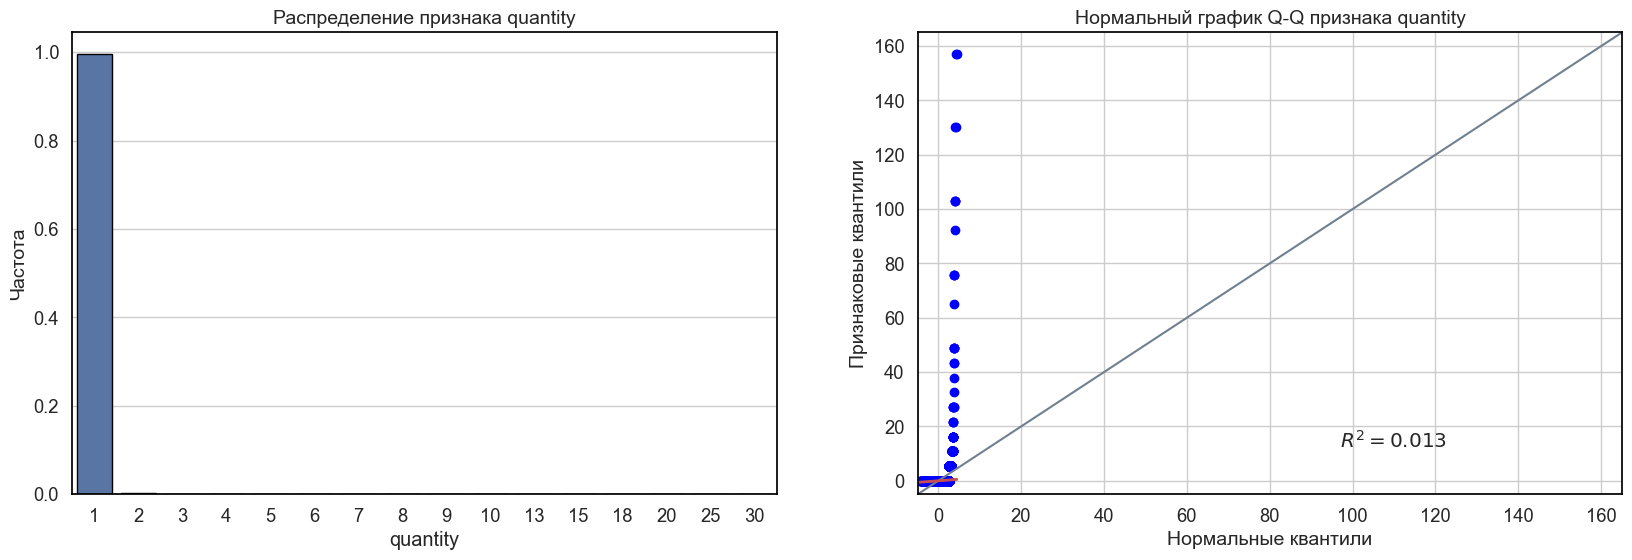

,count,mean,std,min,25%,50%,75%,max
quantity,202208.0,1.006483,0.184384,1.0,1.0,1.0,1.0,30.0


In [23]:
describe_column(data_purchases['quantity'])

Признак `quantity` у 99.6 % клиентов равен 1, при этом соотношение по таргету сохраняется, ну и распределение логнормальное

Добавим новый признак `total_cart` как `quantity` * `price`

In [24]:
data_purchases['total_cart'] = data_purchases['price'] * data_purchases['quantity']

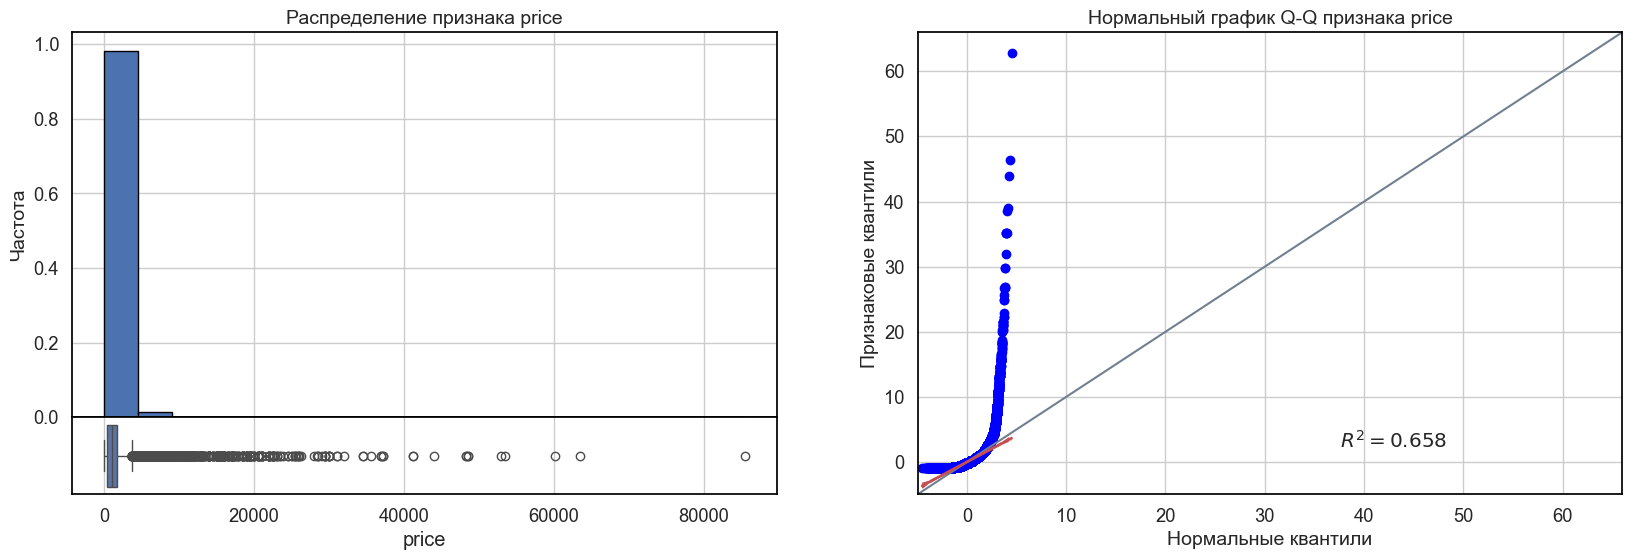

,count,mean,std,min,25%,50%,75%,max
price,202208.0,1193.301516,1342.252664,1.0,352.0,987.0,1699.0,85499.0


In [25]:
describe_column((data_purchases['price']))

Признак так же логнормальный. Почти все покупки проходят до 1700 рублей, а половина - до 1000

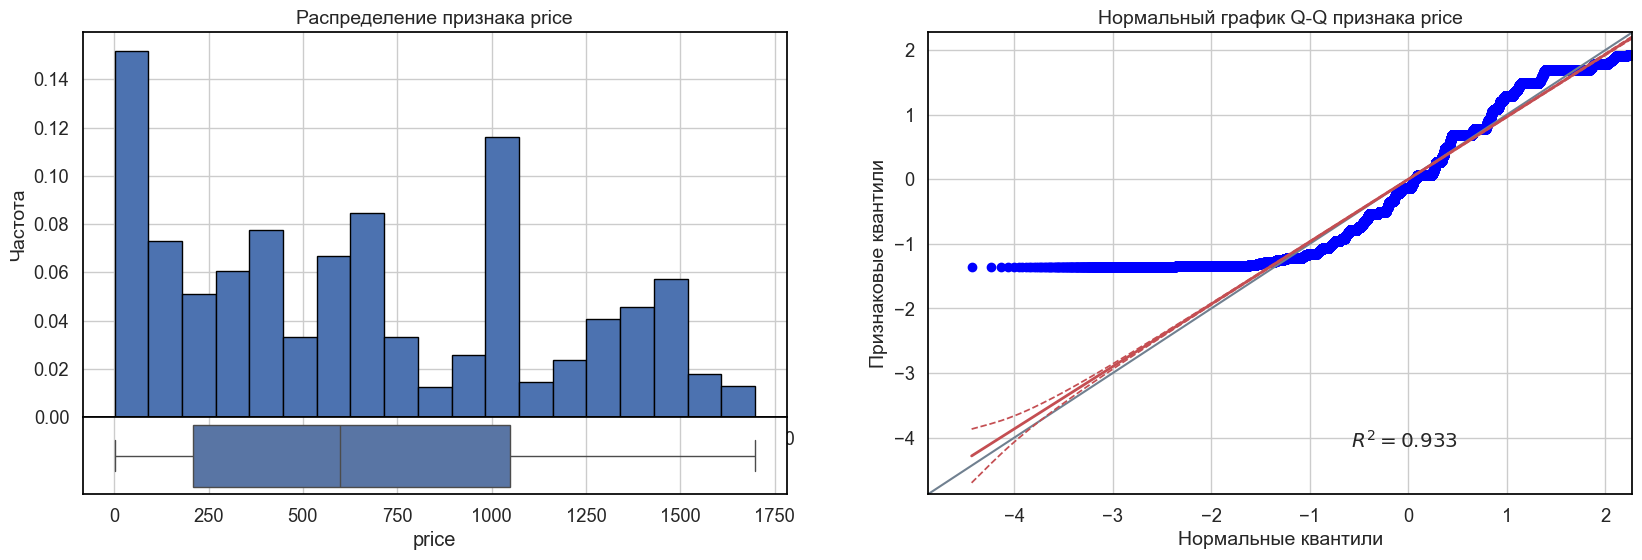

,count,mean,std,min,25%,50%,75%,max
price,150585.0,664.757831,490.828691,1.0,209.0,599.0,1049.0,1698.0


In [26]:
describe_column((data_purchases.query('price < price.quantile(.75)')['price']))

В теории можно будет в аггрегированных данных разбить сумму покупок на перцентили

#### date

Отсечка по датам покупок будет дата последней покупки

In [27]:
last_date = data_purchases['date'].max()
last_date

Timestamp('2024-02-16 00:00:00')

16 февраля 2024

In [28]:
data_purchases['date'].min()

Timestamp('2022-05-16 00:00:00')

То есть данные покупок с 2022-05-16 по 2024-02-16

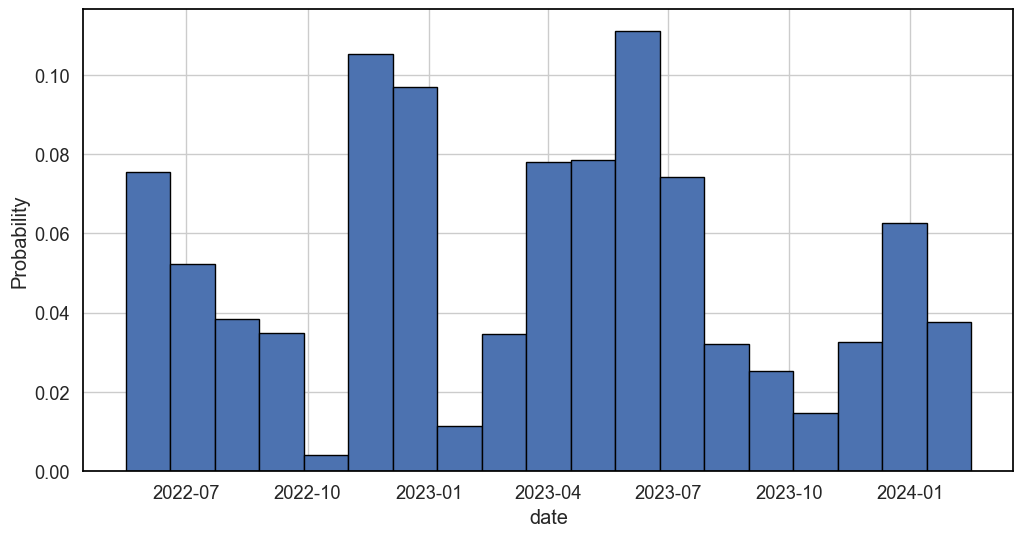

In [29]:
fig = plt.figure(figsize=(12,6))
sns.histplot(x=data_purchases['date'],
                         bins='sturges',
                         alpha=1,
                         edgecolor='black',
                         stat='probability');

Видны периоды покупок:
- предновогодние праздники - декабрь
- весна-лето, праздники, поездки и все такое, настроение лучше, больше можно потратиться
- вероятно в декабре и какие-то праздничные дни действуют всякие акции

Нам необходимо предсказать совершит ли клиент покупку в следующие 90 дней, то есть после февраля - весной, в теории можно все анализировать нормализуя на квартал, так и поступим. Тогда наша задача сведется к предсказанию покупки в следующем квартале

Разобъем все даты по кварталам, причем последние две недели мая 2022 запишем в 1 квартал, так как оттуда собирались данные.

*Нумерация кварталов в нашем определении - это сезон = время года, сдвинутый на 2 назад, то есть лето 2022 - 1 сезон/квартал

In [30]:
data_purchases['quarter_period'] = data_purchases['date'].apply(
    lambda x: round(((x.year - 2022) * 12 + x.month - 4) / 3))
data_purchases.loc[data_purchases['quarter_period']==0, 'quarter_period'] = 1
data_purchases['quarter_period'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

Всего получилось 7 кварталов

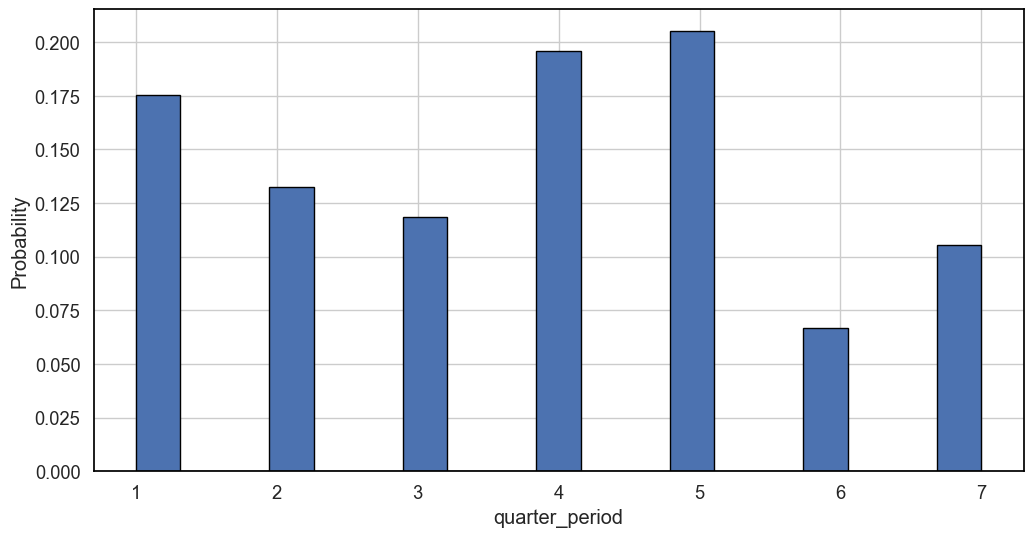

In [31]:
fig = plt.figure(figsize=(12,6))
sns.histplot(x=data_purchases['quarter_period'],
                         bins='sturges',
                         alpha=1,
                         edgecolor='black',
                         stat='probability');

Видно, что максимум покупок за период наблюдения приходится на лето 2023, весна идет с небольшим отставанием

Так же создадим признаки при аггрегации 
- сколько дней/кварталов пользователь совершал покупки
- количество дней с последней покупки

#### `category`

Мы уже разбили столбец `category_ids` на составляющие, но есть несколько проблем:
- Вложенность категорий может меняться
- Что с этим признаком делать при аггрегации?

Решим проблему изменения вложенности категорий

In [32]:
data_purchases[data_purchases['category_3']
               .isin(data_purchases['category_2'].unique())]['category_3'].unique()

array(['44', None], dtype=object)

In [33]:
display(data_purchases.query('category_2=="44"').head(1))
data_purchases.query('category_3=="44"').head(1)

,client_id,quantity,price,date,message_id,category_1,category_2,category_3,target,total_cart,quarter_period
55348,1515915625489465791,1,193.0,2022-11-15,1515915625489465791-7845-6373358bbb68e,4,44,428,0,193.0,2


,client_id,quantity,price,date,message_id,category_1,category_2,category_3,target,total_cart,quarter_period
13,1515915625493306434,1,199.0,2022-05-16,1515915625493306434-4172-626b944176e60,4,28,44,0,199.0,1


Вот например, наименование `44` встречается в уровнях категорий 2 и 3. В таких случаях будем заменять более полной вложенностью, так как она вносит больше полезной категоризации, чем специфичности (как во втором примере). Верхний уровень трогать не будем, так как там может быть идентификатор скидки, например

In [34]:
# наименования верхней категории, встречающиеся в следующей по уровню
filter_intersect = data_purchases['category_2'].isin(data_purchases['category_3']
                                                     .dropna()
                                                     .unique())

cat_intersect = data_purchases[filter_intersect]['category_2'].unique()

for x in cat_intersect:
    data_purchases.loc[data_purchases['category_2']==x, ['category_2', 'category_3']] = \
        [
            data_purchases.query('category_3==@x')['category_2'].mode()[0], 
            x
        ]

In [35]:
data_purchases.iloc[[55348]]

,client_id,quantity,price,date,message_id,category_1,category_2,category_3,target,total_cart,quarter_period
55348,1515915625489465791,1,193.0,2022-11-15,1515915625489465791-7845-6373358bbb68e,4,28,44,0,193.0,2


Получилось, отлично! Теперь посмотрим на категории и подумаем по ходу дела, что можно использовать в аггрегации

#### `category_1`

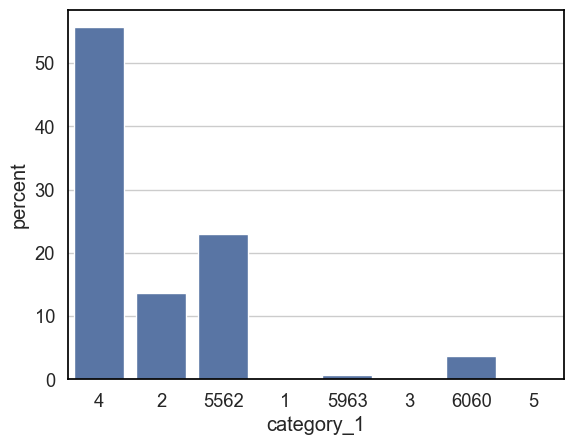

In [36]:
sns.countplot(x=data_purchases['category_1'], stat='percent');

По самой общей категории видим, что чуть больше половины покупок происзодит в `4` категории, чуть больше 20 % в `5562`, около 13 % во `2` категории и около 3 % в `6060`, в остальных - покупок заметно меньше процента.

Посмотрим на возможные ветки категорий `1`, `3`, `5` и `5963`

In [37]:
data_purchases.query('category_1=="1"')

,client_id,quantity,price,date,message_id,category_1,category_2,category_3,target,total_cart,quarter_period
5990,1515915625666901395,1,199.0,2022-06-01,1515915625666901395-4698-62971583c7270,1,8,280,0,199.0,1
22938,1515915625489044168,1,1799.0,2022-07-12,1515915625489044168-5335-62c7d2d6bd056,1,22,50,0,1799.0,1
29809,1515915625789566616,1,1799.0,2022-08-07,1515915625789566616-5785-62ecc38c85606,1,22,50,0,1799.0,1


In [38]:
data_purchases.query('category_1=="3"')

,client_id,quantity,price,date,message_id,category_1,category_2,category_3,target,total_cart,quarter_period
43207,1515915625503627622,1,39.0,2022-11-10,1515915625503627622-7737-636c9e0815907,3,14,79,0,39.0,2
43208,1515915625503627622,1,39.0,2022-11-10,1515915625503627622-7737-636c9e0815907,3,14,79,0,39.0,2
57458,1515915625862933230,1,39.0,2022-11-15,1515915625862933230-7882-637397f5c0836,3,14,79,0,39.0,2
57459,1515915625862933230,1,39.0,2022-11-15,1515915625862933230-7882-637397f5c0836,3,14,79,0,39.0,2
127992,1515915625585330745,1,1547.0,2023-06-03,1515915625759495104-13067-647985a9c670e,3,12,219,0,1547.0,5
127993,1515915625585330745,1,1547.0,2023-06-03,1515915625759495104-13067-647985a9c670e,3,12,219,0,1547.0,5
128098,1515915625759495104,1,1999.0,2023-06-03,1515915625759495104-13067-647985a9c670e,3,12,219,0,1999.0,5
162783,1515915625766046134,1,1373.0,2023-08-11,1515915625766046134-13635-64d61ad476a9f,3,12,219,0,1373.0,5
162784,1515915625766046134,1,1373.0,2023-08-11,1515915625766046134-13635-64d61ad476a9f,3,12,219,0,1373.0,5
185054,1515915625928604160,1,839.0,2023-12-22,1515915625928604160-14352-658557e4574b6,3,12,219,0,839.0,7


In [39]:
data_purchases.query('category_1=="5"')

,client_id,quantity,price,date,message_id,category_1,category_2,category_3,target,total_cart,quarter_period
108856,1515915625500375788,1,140.0,2023-04-24,1515915625500375788-12020-644103f7b6eed,5,10,105,0,140.0,4
108857,1515915625500375788,1,140.0,2023-04-24,1515915625500375788-12020-644103f7b6eed,5,10,105,0,140.0,4


In [40]:
print('Объектов в category_1=5934 - ', data_purchases.query('category_1=="5963"').shape[0])
data_purchases.query('category_1=="5963"').head()

Объектов в category_1=5934 -  1272


,client_id,quantity,price,date,message_id,category_1,category_2,category_3,target,total_cart,quarter_period
42112,1515915625555349620,1,69.0,2022-11-04,1515915625555349620-7576-63637524451ba,5963,5959,6023,0,69.0,2
42113,1515915625555349620,1,1.0,2022-11-04,1515915625555349620-7576-63637524451ba,5963,5959,6023,0,1.0,2
42534,1515915625862844356,1,64.0,2022-11-04,1515915625499837520-7602-6364bc166ef3f,5963,5959,6023,0,64.0,2
43563,1515915625701187716,1,140.0,2022-11-10,1515915625701187716-7745-636bb5f9e58f4,5963,5959,6022,0,140.0,2
43564,1515915625701187716,1,128.0,2022-11-10,1515915625701187716-7745-636bb5f9e58f4,5963,5959,6022,0,128.0,2


In [41]:
data_purchases.query('category_1=="5963"')['target'].value_counts()

target
0    1236
1      36
Name: count, dtype: int64

In [42]:
data_purchases.query('category_1=="other"')['target'].value_counts()

Series([], Name: count, dtype: int64)

Видим, что в `1`, `3` и `5` всего 16 объектов, в `5934` - 1272, очень мало, за 1.5 года наблюдений и при условии, что выборка более менее репрезентативна - очень непопулярные категории, и предсказать возможную покупку в каждой из них представляется затруднительным, поэтому объединим их в одну категорию `other`, которыми заполним пропуски. Кроме того, в `5963` только одна подкатегория `5959`

Так у нас будет чуть больше вероятность, если вдруг появится настоящий потенциальный покупатель в `1`, `3` и `5`, и сохранится распределение `0` и `1` в таргете

In [43]:
cat_1 = ['1', '3', '5', '5963']
data_purchases[['category_2', 'category_3']].isin(cat_1).sum()

category_2    0
category_3    0
dtype: int64

Проверили на всякий случай пересечния с другими категориями - их нет

In [44]:
cat_1 = ["1", "3", "5", "5963", None]
data_purchases.loc[data_purchases['category_1'].isin(cat_1), 
                   ['category_1']] = 'other'
data_purchases['category_2'].fillna('Unknown', inplace=True)
data_purchases['category_3'].fillna('Unknown', inplace=True)

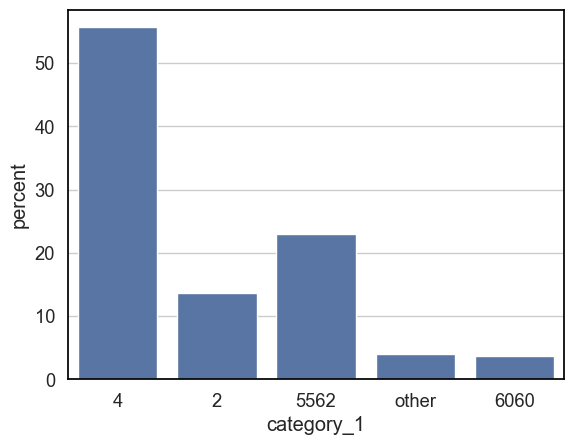

In [45]:
sns.countplot(x=data_purchases['category_1'], stat='percent');

Отлично, в самой общей категории теперь 5 наименований, вместо 9

- Во время аггрегации выделим у каждого пользователя 3 любимые категории из 2 уровня категорий, если у него их будет меньше, то на пропуски поставим загулшку `no`, так будет более специфичен выбор - наименование из разовых покупок, вроде чехла для телефона, который покупают редко, или химия для авто, которую покупают с некоторой периодичностью
- Дополнительно добавим столбцы - число покупок пользователя в каждой из категорий первого уровня - 5 штук, заодно подсветятся клиенты, которые покупают только по скидкам

#### `category_2` и `category_3`

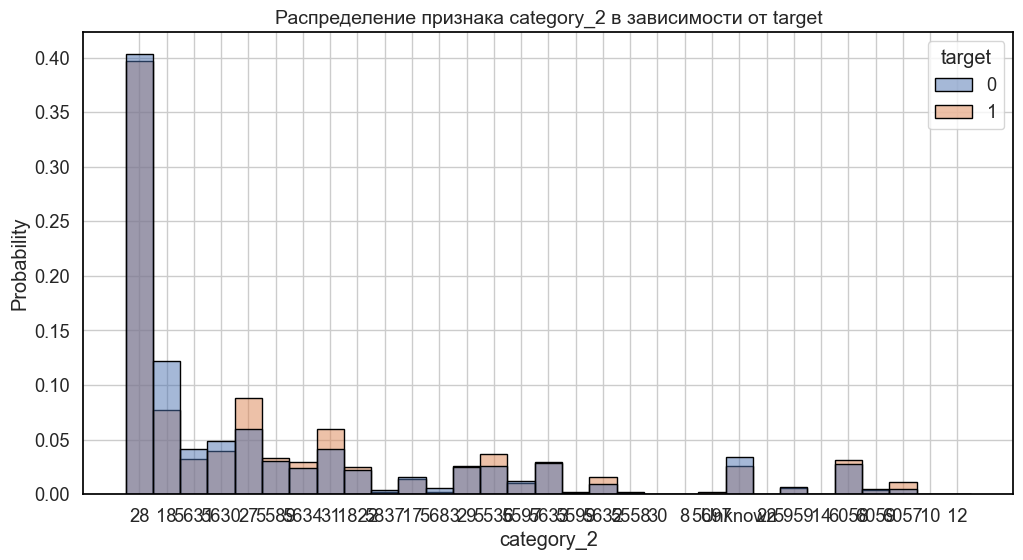

In [46]:
describe_column(data_purchases['category_2'], hue=data_purchases['target'], alpha=0.5)

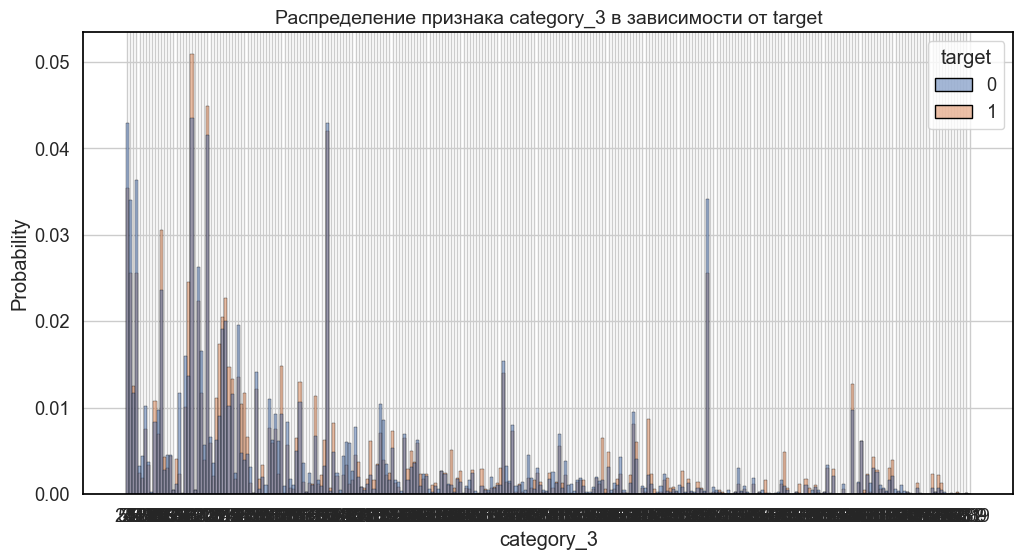

In [47]:
describe_column(data_purchases['category_3'], hue=data_purchases['target'], alpha=0.5)

В категории 3 уровня есть много категорий с разным первалированием по классам, попробуем посмотреть на топ 50 по разнице нормализованных классов, чтобы выбрать самые значимые категории

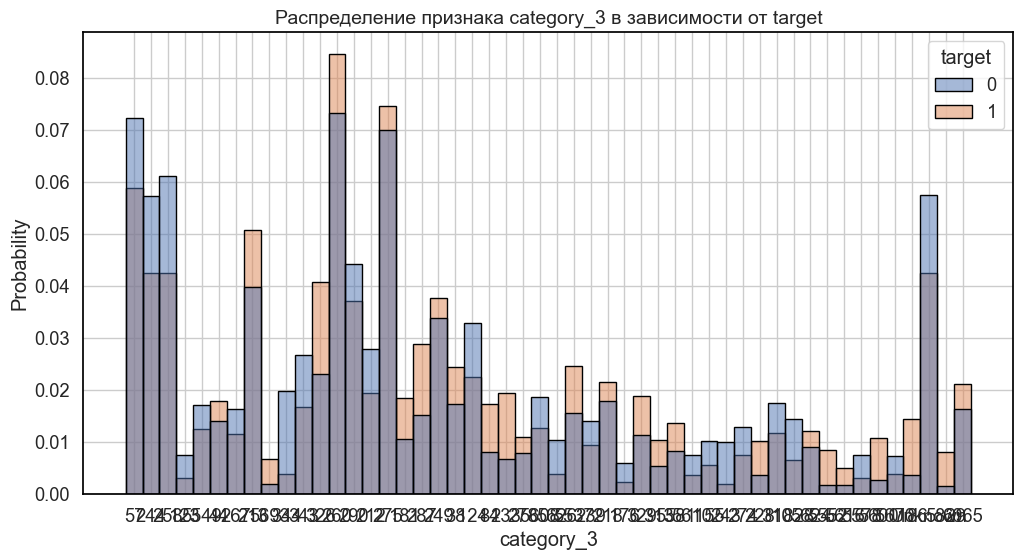

In [48]:
cat_3_pos = (data_purchases
             .query('target==1')['category_3']
             .value_counts(normalize=True)
             .sort_index())
cat_3_neg = (data_purchases
             .query('target==0')['category_3']
             .value_counts(normalize=True)
             .sort_index())
top50 = (cat_3_pos-cat_3_neg).abs().sort_values(ascending=False).head(50).index.to_list()
describe_column(data_purchases.query('category_3.isin(@top50)')['category_3'], 
                hue=data_purchases['target'], 
                alpha=0.5)

Отлично, позже используем этот топ-50 из категории 3 уровня

### `data_messages`

In [49]:
data_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19 00:56:52


Мы уже видели, что не все клиенты, покупавшие товары представлены в этой таблице. Аггрегировать на каждого клиента будем не по кварталам, а за год. Хотя можно дублировать признаки за последний квартал или разницей последнего с предпоследним кварталом

#### `created_at`

In [50]:
print('Начало сбора данных - ', data_messages['created_at'].min())
print('Начало сбора данных - ', data_messages['created_at'].max())

Начало сбора данных -  2022-05-19 00:14:20
Начало сбора данных -  2024-02-15 23:58:40


Адекватно перескается данными покупок

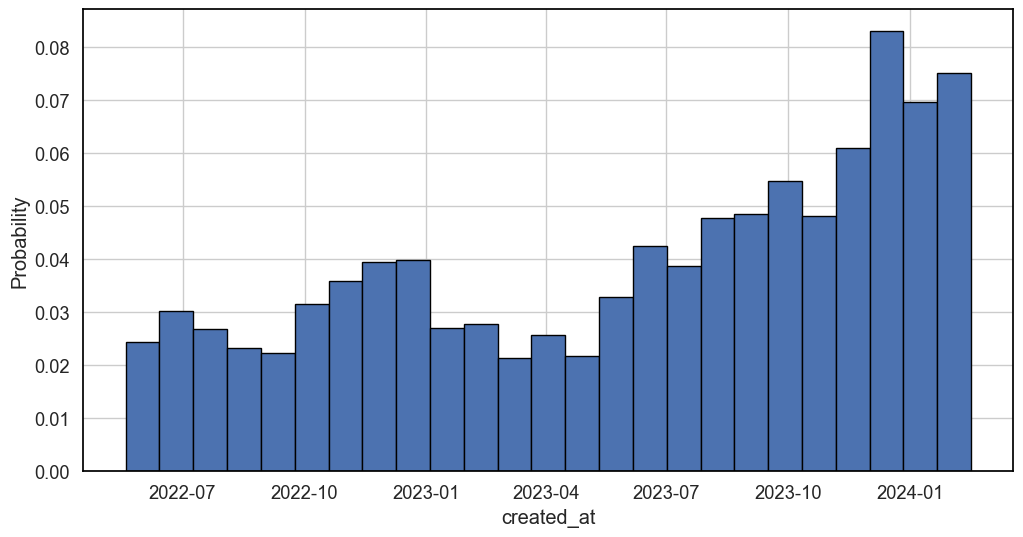

In [51]:
fig = plt.figure(figsize=(12,6))
sns.histplot(x=data_messages['created_at'],
                         bins='sturges',
                         alpha=1,
                         edgecolor='black',
                         stat='probability');

Вид маркетинговой активности отличается от распределения покупок, какой-то связи нет. Видно, что с лета 2023 начинает расти и поднимается более чем в 2.5 раза к концу наблюдений

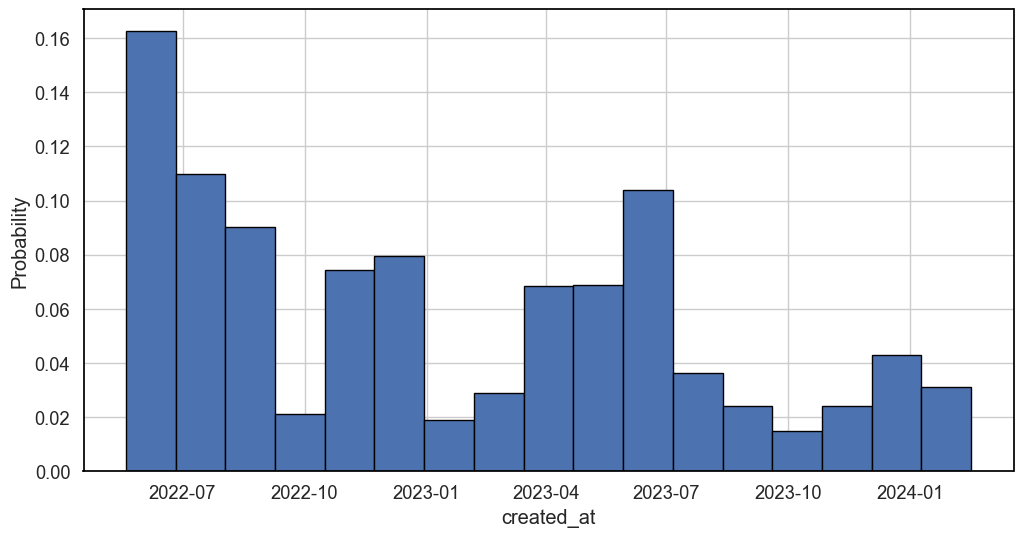

In [52]:
fig = plt.figure(figsize=(12,6))
sns.histplot(x=data_messages.query('event=="purchase"')['created_at'],
                         bins='sturges',
                         alpha=1,
                         edgecolor='black',
                         stat='probability');

Распределение сообщений о покупке вообще не похоже на картину в покупках, что говорит о плохой связи между данными, хотя некоторые паттерны есть, вроде всплесков в похоже периоды

#### `event`

In [53]:
data_messages['event'].value_counts(normalize=True) * 100

event
send           71.373728
open           24.051972
click           3.808359
purchase        0.493200
hard_bounce     0.155722
soft_bounce     0.083381
unsubscribe     0.022323
hbq_spam        0.006485
complain        0.004152
subscribe       0.000670
close           0.000008
Name: proportion, dtype: float64

В первую очередь создадим признак `subscribe - unsubscribe` - хоть их и мало, но так отдельно выделим тех, кто подписался на рассылку или отписался, тут по вероятностям может быть связь

In [54]:
print('Подписок', data_messages.query('event=="subscribe"')['client_id'].count())
print('Отписок', data_messages.query('event=="unsubscribe"')['client_id'].count())

Подписок 85
Отписок 2833


Далее посмотрим активность пользователя:
- `open` / `send` - может много раз открывать рассылку
- `click` / `send` - может кликать много раз или наоборот пропускать
- `purchase` / `send` - сколько раз покупает из всех рассылок

#### `channel`

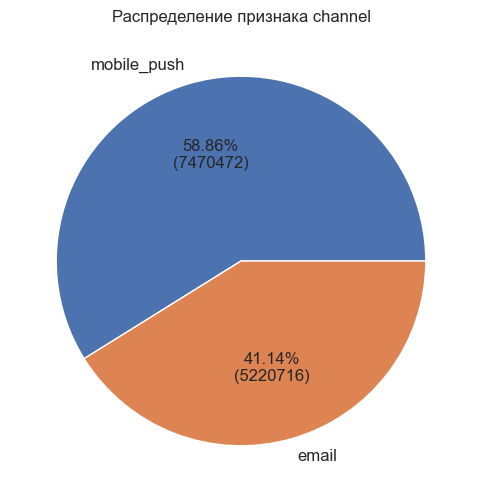

In [55]:
describe_column(data_messages['channel'])

Добавим признаки - сколько сообщений получил через `mobile_push` и сколько через `email`

### Аггрегация

Итак, нам необходимо создать новые признаки через аггрегацию, еще раз укажем новые признаки:
- **`data_purchases`**
    - `total_spend` - сколько всего потратил
    - `total_purch` - сколько совершил покупок
    - `med_purch_price` - медианная стоимость покупки
    - `fav_cat_3` - любимая категория из третьего уровня
    - `days_total_purch` - сколько дней пользователь совершал покупки
    - `days_since_last_purch` - количество дней с последней покупки
    - `active_purch_days` - количество дней с покупками
    - `av_days_between_purch` - количество дней между покупками


- **`data_messages`**
    - `subscribtion` - `subscribe - unsubscribe` - подписки/отписки
    - `open_rate` - `open` / `send` - может много раз открывать рассылку
    - `click_rate` - `click` / `send` - может кликать много раз или наоборот пропускать
    - `mobile_push_count` - сколько сообщений получил через `mobile_push`
    - `email_count` - сколько через `email`
    - `main_campaign` - основная кампания рассылки

In [56]:
# сооберем все по возможности через groupby
df = (data_purchases
      .groupby('client_id', as_index=False)
      .agg(
           total_spend=('total_cart', 'sum'),
           total_purch=('quantity', 'sum'),
           first_purch_date=('date', 'min'),
           last_purch_date=('date', 'max'),
           med_purch_price=('price', 'median'),
           fav_cat_3=('category_3',  lambda x: pd.Series.mode(x)[0])
          )
     )

In [57]:
# оставим только значимые из любимых категорий
df['fav_cat_3'] = df['fav_cat_3'].apply(lambda x: x if x in top50 else 0).astype('category')

In [58]:
# количесвто дней с активными покупками, количество дней между покупками
pivot_ = (data_purchases
          .groupby(['client_id', 'date'], as_index=False)
          .agg(
              day_spend=('total_cart', 'sum'),
              day_purch=('quantity', 'sum'))
          .groupby('client_id', as_index=False)
          .agg(
              active_purch_days=('date', 'count'),
              av_days_between_purch=('date', lambda x: x.diff().dt.days.mean()))
         ).fillna(value={'av_days_between_purch': np.nan})
df = df.merge(pivot_, on='client_id', how='left')

In [59]:
# колиечство дней по покупкам и сколько дней с последней
df['days_total_purch'] = (df['last_purch_date'] - df['first_purch_date']).dt.days + 1
df['days_since_last_purch'] = (data_purchases['date'].max() - df['last_purch_date']).dt.days + 1
df.drop(['first_purch_date', 'last_purch_date'], axis=1, inplace=True)

In [60]:
# добавляем статистику по event из data_messages
pivot_ = pd.pivot_table(data_messages, 
                        values='bulk_campaign_id', 
                        index='client_id', 
                        columns='event', 
                        aggfunc='count', fill_value=0).reset_index().rename_axis(None, axis=1)
pivot_['subscribtion'] = pivot_['subscribe'] - pivot_['unsubscribe']
pivot_= pivot_[['client_id', 'open', 'click', 'subscribtion']]
df = df.merge(pivot_, on='client_id', how='left')

In [61]:
# добавляем статистику по channel из data_messages
pivot_ = pd.pivot_table(data_messages, 
                        values='bulk_campaign_id', 
                        index='client_id', 
                        columns='channel', 
                        aggfunc='nunique', fill_value=0)
pivot_ = pivot_.add_suffix('_count').reset_index().rename_axis(None, axis=1)

df = df.merge(pivot_, on='client_id', how='left')

df['open_rate'] = df['open'] / ((data_messages['bulk_campaign_id'].nunique() + 1) - \
                                (df['email_count'] + df['mobile_push_count']))
df['click_rate'] = df['click'] / ((data_messages['bulk_campaign_id'].nunique() + 1) - \
                                (df['email_count'] + df['mobile_push_count']))
df.drop(['open', 'click'], axis=1, inplace=True)

In [62]:
# основная кампнаия рассылки
pivot_ = (data_messages
          .groupby('client_id', as_index=False)
          .agg(main_campaign=('bulk_campaign_id', lambda x: pd.Series.mode(x)[0]))
         ).fillna(-1)
df = df.merge(pivot_, on='client_id', how='left')

In [63]:
df = df.merge(data_target, on='client_id', how='left')

In [64]:
del data_purchases, data_messages, data_target

In [65]:
display(df.head(10))
df.info()

,client_id,total_spend,total_purch,med_purch_price,fav_cat_3,active_purch_days,av_days_between_purch,days_total_purch,days_since_last_purch,subscribtion,email_count,mobile_push_count,open_rate,click_rate,main_campaign,target
0,1515915625468060902,6993.0,7,999.0,176,1,NaN,1,631,-1.0,127.0,0.0,0.013550,0.003871,4617.0,0
1,1515915625468061003,16235.0,7,2100.0,249,1,NaN,1,409,0.0,154.0,0.0,0.001956,0.001956,9148.0,1
2,1515915625468061099,299.0,1,299.0,290,1,NaN,1,641,0.0,157.0,58.0,0.020441,0.003206,9945.0,0
3,1515915625468061100,2098.0,2,1049.0,1828,1,NaN,1,7,0.0,0.0,265.0,0.064213,0.000409,14280.0,0
4,1515915625468061170,33601.0,19,2195.0,260,3,41.5,84,245,0.0,164.0,76.0,0.012551,0.006478,11144.0,0
5,1515915625468061514,999.0,1,999.0,239,1,NaN,1,567,0.0,150.0,0.0,0.006641,0.004687,14085.0,0
6,1515915625468061877,1499.0,1,1499.0,0,1,NaN,1,547,0.0,38.0,132.0,0.019685,0.001969,14276.0,0
7,1515915625468061975,299.0,1,299.0,0,1,NaN,1,570,0.0,154.0,0.0,0.006651,0.002739,5662.0,0
8,1515915625468061994,1012.0,8,114.0,6065,2,29.0,30,430,0.0,96.0,243.0,0.008857,0.003796,14272.0,0
9,1515915625468062158,6096.0,4,1449.0,275,2,340.0,341,295,0.0,113.0,0.0,0.010782,0.011167,9856.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   client_id              49849 non-null  int64   
 1   total_spend            49849 non-null  float64 
 2   total_purch            49849 non-null  int64   
 3   med_purch_price        49849 non-null  float64 
 4   fav_cat_3              49849 non-null  category
 5   active_purch_days      49849 non-null  int64   
 6   av_days_between_purch  7143 non-null   float64 
 7   days_total_purch       49849 non-null  int64   
 8   days_since_last_purch  49849 non-null  int64   
 9   subscribtion           41982 non-null  float64 
 10  email_count            41982 non-null  float64 
 11  mobile_push_count      41982 non-null  float64 
 12  open_rate              41982 non-null  float64 
 13  click_rate             41982 non-null  float64 
 14  main_campaign          41982 non-null 

Отлично, сконструировали 14 признаков!

### Корреляционный анализ

In [66]:
df.drop('client_id', axis=1, inplace=True)

In [67]:
# общая матрица корреялции
interval_cols = [
                'open_rate',
                'click_rate',
                'av_days_between_purch',
                'most_freq_campaign',
                'bulk_campaign',
                'med_purch_price',
                'total_spend'
                ]

corr_matrix = df.dropna().phik_matrix(interval_cols=interval_cols)

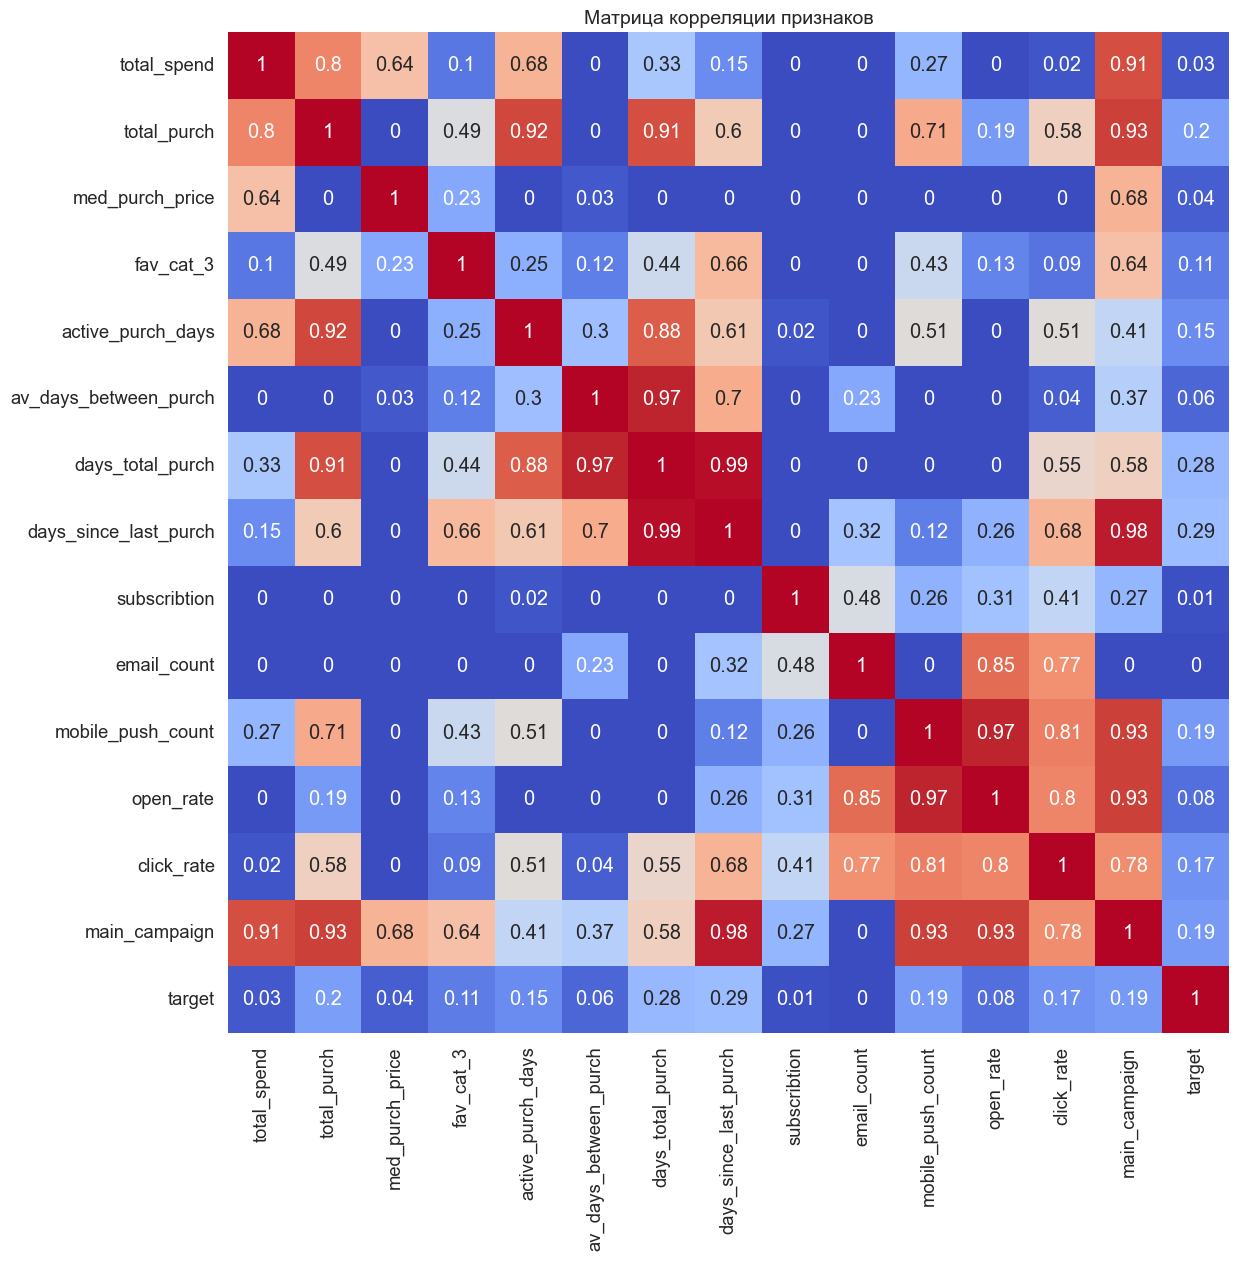

In [68]:
plt.figure(figsize=(13, 13))
plt.title('Матрица корреляции признаков',
          fontsize=14)
sns.heatmap(corr_matrix.round(2), 
            annot = True, square=True, 
            cmap='coolwarm', 
            cbar=False);

Есть мультиколлинеарности, но нам без разницы, потому что будем использовать деревья (бустинг)

In [69]:
# VIF анализ
cols_= ['const'] + df.select_dtypes(exclude='O').columns.to_list()
cols_ = ['const',
 'total_spend',
 'total_purch',
 'med_purch_price',
 'active_purch_days',
 'av_days_between_purch',
 'days_total_purch',
 'days_since_last_purch',
 'subscribtion',
 'open_rate',
 'click_rate',
 'email_count',
 'mobile_push_count',
 'main_campaign']

df_ = add_constant(df.dropna().reset_index())

vif_data = pd.DataFrame()
vif_data['feature'] = df_[cols_].columns
vif_data['VIF'] = [variance_inflation_factor(df_[cols_].values, i) 
                          for i in range(len(df_[cols_].columns))]
vif_data

,feature,VIF
0,const,50.268716
1,total_spend,2.131976
2,total_purch,1.997497
3,med_purch_price,1.719596
4,active_purch_days,3.345213
5,av_days_between_purch,7.688663
6,days_total_purch,9.744346
7,days_since_last_purch,2.097713
8,subscribtion,1.014829
9,open_rate,1.690679


По вариационному анализу дисперсии все в порядке

### Вывод

- Данные сильно несбалансированы - 1:50
- Сконструировали следующие признаки

    - **`data_purchases`**
        - `total_spend` - сколько всего потратил
        - `total_purch` - сколько совершил покупок
        - `med_purch_price` - медианная стоимость покупки
        - `fav_cat_3` - любимая категория из третьего уровня
        - `days_total_purch` - сколько дней пользователь совершал покупки
        - `days_since_last_purch` - количество дней с последней покупки
        - `active_purch_days` - количество дней с покупками
        - `av_days_between_purch` - количество дней между покупками
    - **`data_messages`**
        - `subscribtion` - `subscribe - unsubscribe` - подписки/отписки
        - `open_rate` - `open` / `send` - может много раз открывать рассылку
        - `click_rate` - `click` / `send` - может кликать много раз или наоборот пропускать
        - `mobile_push_count` - сколько сообщений получил через `mobile_push`
        - `email_count` - сколько через `email`
        - `main_campaign` - основная кампания рассылки

В данных есть некоторая мультиколлинеарность, но так как будем использовать деревья - нам это не помеха

## Подбор модели

In [70]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

In [71]:
def objective(params):
   # Define classifier
    lgbm = LGBMClassifier(**params)
    
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
    
    score = cross_val_score(estimator=lgbm, X=X_train, y=y_train, 
                            scoring='roc_auc', cv=skf, n_jobs=-1)
    
    # Return results
    return {'loss': -score.mean(),
            'status': STATUS_OK,
            'model': lgbm
           }

In [72]:
param_space = {
                'random_state': RANDOM_STATE,
                'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
                'max_depth': hp.choice('max_depth', np.arange(2, 4, dtype=int)),
                'n_estimators' : hp.choice('n_estimators', np.arange(2000, 7000, 500, dtype=int)),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
                'scale_pos_weight' : 51,
                'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
                'verbose': -1
                }

In [73]:
trials = Trials()

In [74]:
results = fmin(
                objective,
                space=param_space,
                algo=tpe.suggest,
                trials=trials,
                max_evals=50,
                rstate=np.random.default_rng(RANDOM_STATE)
              )

100%|███████████████████████████████████████████████| 50/50 [05:24<00:00,  6.48s/trial, best loss: -0.7332604601289681]


In [75]:
trials.results

def getBestModelfromTrials(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [ float(trial['result']['loss']) for trial in valid_trial_list]
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    return best_trial_obj['result']['model']

best_model = getBestModelfromTrials(trials)
best_model.fit(X_train, y_train)
best_model

LGBMClassifier(feature_fraction=0.5046969586690848,
               learning_rate=0.001903220948396386, max_depth=2,
               n_estimators=3000, random_state=42,
               reg_lambda=1.4797301794899655, scale_pos_weight=51, verbose=-1)

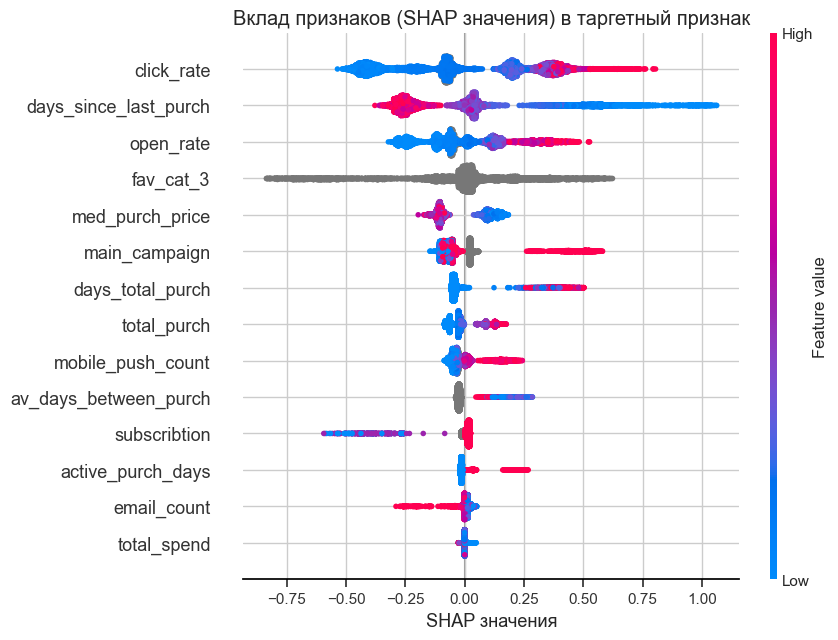

In [76]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer(X_valid, check_additivity=False)
shap.plots.beeswarm(shap_values[:,:,1], max_display=15, show=False)
plt.title('Вклад признаков (SHAP значения) в таргетный признак')
plt.xlabel('SHAP значения');

Наиболее важными признаками являются:
- `click_rate` - с ростом кликов растет вероятность покупки
- `days_since_last_purch` - чем меньше дней с последней покупки, тем вероятнее покупка
- `fav_cat_3` 
- `open_rate` - с ростом открытий рассылок растет вероятность покупки
- `med_purch_price` - чем меньше медианная цена товаров, которые покупал клиент, тем вероятнее еще раз совершит покупку
- `main_campaign`
- `email_count` и `mobile_push_count` - лучше рассылать больше пушей, чем эл.писем
- `subscription` - пользователи с отпиской или без менее вероятно что-то купят

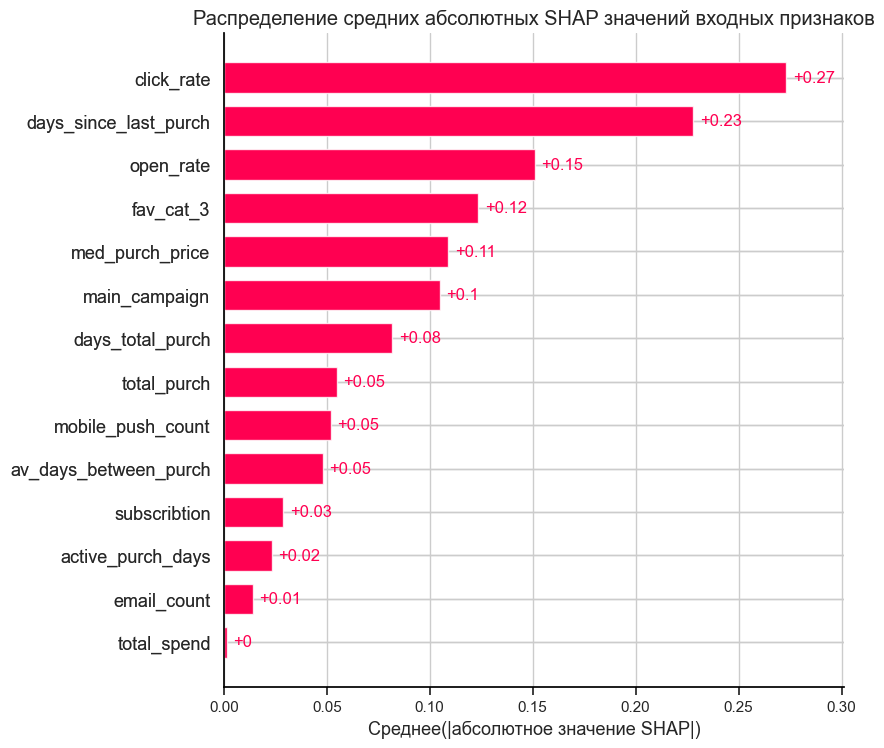

In [77]:
shap.plots.bar(shap_values[:,:,1], max_display=15, show=False)
plt.title('Распределение средних абсолютных SHAP значений входных признаков')
plt.xlabel('Среднее(|абсолютное значение SHAP|)');

### Метрики модели

In [78]:
# Создадим функцию для вывода метрики модели
# Принимает на вход y_test - тестовая выборка, predictions - предсказание целевого признака
def model_metrics(y_test, predictions, proba, name):
    print(f'ROC-AUC - {round(roc_auc_score(y_test, proba), 3)}')
    print(f'Recall - {round(recall_score(y_test, predictions), 3)}')
    print(f'Precision - {round(precision_score(y_test, predictions, average="weighted"), 3)}')
    print(f'F1 score - {round(f1_score(y_test, predictions, average="weighted"), 3)}')
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
    plt.title(f'Матрица ошибок {name}')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')

ROC-AUC - 0.76
Recall - 0.63
Precision - 0.972
F1 score - 0.843


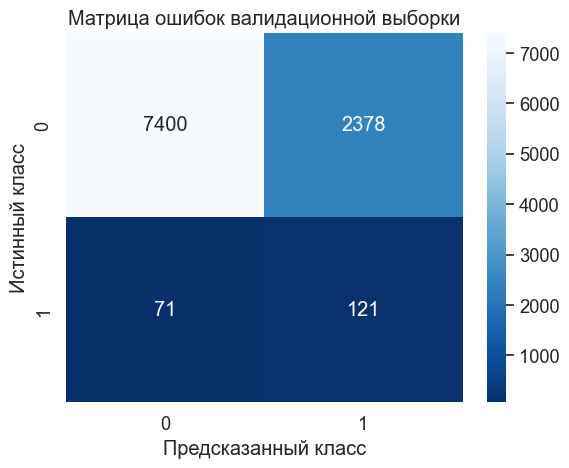

In [79]:
model_metrics(y_valid,
              best_model.predict(X_valid),
              best_model.predict_proba(X_valid)[:,1],
              'валидационной выборки')

Посмотрим какой результат выдает dummy модель

ROC-AUC - 0.507
Recall - 0.031
Precision - 0.963
F1 score - 0.964


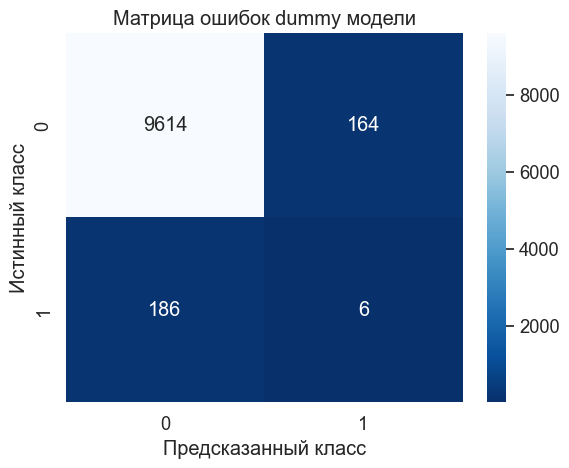

In [80]:
dummy_class = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_class.fit(X_train, y_train)
y_dummy_predict = dummy_class.predict(X_valid)
y_dummy_proba = dummy_class.predict_proba(X_valid)[:,1]
model_metrics(y_valid, y_dummy_predict, y_dummy_proba, 'dummy модели')

Явно хуже

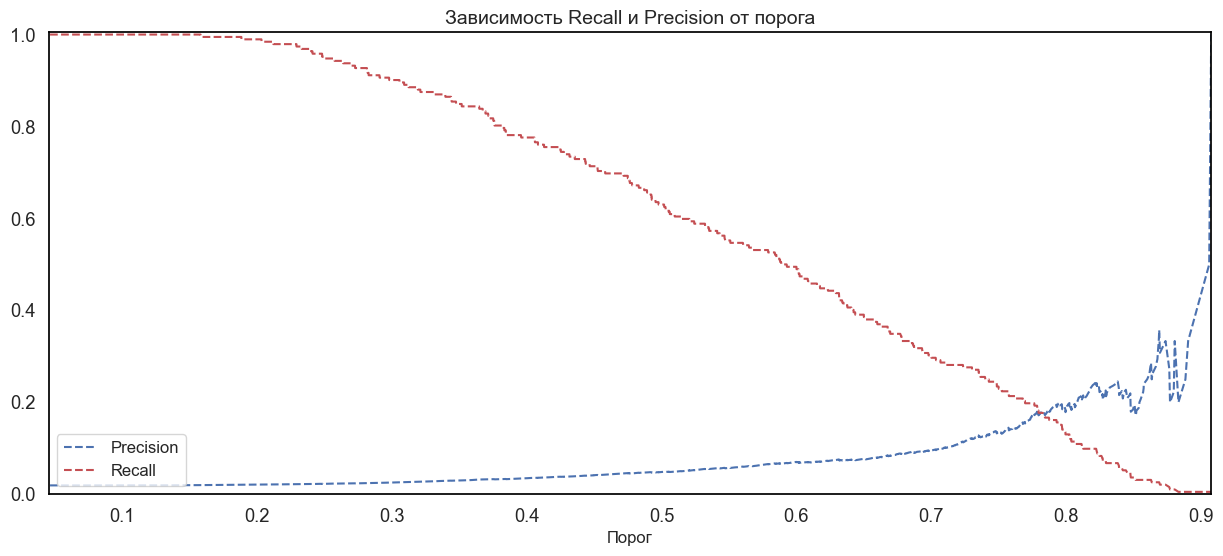

In [81]:
# Найдем все значения precision, recall и порога для тестовой выборки и предсказаний
precision, recall, threshold  = precision_recall_curve(y_valid, 
                                                       best_model.predict_proba(X_valid)[:,1])

# Построим графики зависимостей
plt.figure(figsize=(15,6))
plt.title('Зависимость Recall и Precision от порога', fontsize=14)
plt.plot(threshold, precision[:-1], 'b--', label='Precision')
plt.plot(threshold, recall[:-1], 'r--', label='Recall')
plt.xlabel('Порог', fontsize=12)
plt.legend(loc='lower left', fontsize=12)
plt.ylim([0,1.005])
plt.xlim([min(threshold)-0.001,max(threshold)])
plt.grid();

Можно было бы подобрать порог. Понятно, что заказчику желательно выявить всех покупателей, но слишком сильно упадет precision. В теории, для заказчика хорошо даже 5 % покупателей на таких данных, если мы их хорошо выявим. 

ROC-AUC - 0.76
Recall - 0.297
Precision - 0.968
F1 score - 0.949


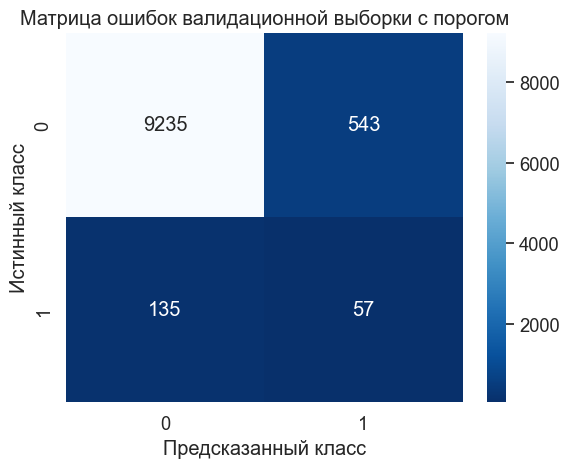

In [85]:
# Немного варьируем порог и рассчитываем метрику модели с порогом
pred_with_threshold = (best_model.predict_proba(X_valid)[:,1] > 0.7).astype(int)
model_metrics(y_valid, 
              pred_with_threshold, 
              best_model.predict_proba(X_valid)[:,1], 
              'валидационной выборки с порогом')

Выберем порог 0.7, тогда из тех пользователей, которым заказчик может сделать какое-либо предложение, около 10 % совершат покупку - неплохая конверсия

### Вывод

С помощью оптимизационного поиска HyperOpt подобрали гиперпараметры для LGBMClassifier. В результате на тестовой выборке получилась следующая метрики:

- `ROC-AUC` - 0.76
- `Weigthed Recall` - 0.63
- `Weighted F1 score` - 0.843


Для более прикладного результата выбрали порог 0.7 для классификатора, чтобы около 10% клиентов, на которых заказчик направил усилия совершили покупку. В результате получаются следующие метрики:

- `ROC-AUC` - 0.759
- `Weigthed Recall` - 0.297
- `Weighted F1 score` - 0.949

Наиоблее важными признаками для модели являются:

- `click_rate` - с ростом кликов растет вероятность покупки
- `days_since_last_purch` - чем меньше дней с последней покупки, тем вероятнее покупка
- `fav_cat_3` 
- `open_rate` - с ростом открытий рассылок растет вероятность покупки
- `med_purch_price` - чем меньше медианная цена товаров, которые покупал клиент, тем вероятнее еще раз совершит покупку
- `main_campaign`
- `email_count` и `mobile_push_count` - лучше рассылать больше пушей, чем эл.писем

## Общий вывод

В результате работы на основе данных заказчика была построена модель классификации покупателя `LGBMClassifier` для которой были сконструированы 14 признаков, найдены подходящие гиперпараметры с помощью Hyperopt и кроссвалидацией с 2 фолдами. `ROC-AUC` метрика для данной модели 0.76. Размер тестовой выбокри - 0.2

**Исходные данные**

- **`data_purchases`**
    - `apparel-purchases.csv`
    - 202 тыс записей
    - уникальных клиентов - 49849
       

- **`data_messages`**
    - `apparel-messages.csv`
    - 12.7 млн записей
    - уникальных клиентов - 53329 


- **`data_target`**
    - `apparel-target_binary.csv`
    - 49849 тыс записей

**Предобработка**
- 5.5 тыс неявных пропусков  `[]` в `category_ids` заполнили `other`
- 48 тыс дубликатов из 12.7 млн записей в `data_messages` выбросили
- 70 тыс дубликатов в `data_purchases` оставили
- Разбили `category_ids` на 3 уровня категорий `category_i`

**Создание признаков**
- **`data_purchases`**
    - `total_spend` - сколько всего потратил
    - `total_purch` - сколько совершил покупок
    - `med_purch_price` - медианная стоимость покупки
    - `fav_cat_3` - любимая категория из третьего уровня
    - `days_total_purch` - сколько дней пользователь совершал покупки
    - `days_since_last_purch` - количество дней с последней покупки
    - `active_purch_days` - количество дней с покупками
    - `av_days_between_purch` - количество дней между покупками
    
    
- **`data_messages`**
    - `subscribtion` - `subscribe - unsubscribe` - подписки/отписки
    - `open_rate` - `open` / `send` - может много раз открывать рассылку
    - `click_rate` - `click` / `send` - может кликать много раз или наоборот пропускать
    - `mobile_push_count` - сколько сообщений получил через `mobile_push`
    - `email_count` - сколько через `email`
    - `main_campaign` - основная кампания рассылки

**Модель**
- С помощью оптимизационного поиска HyperOpt подобрали гиперпараметры для LGBMClassifier:
    - `feature_fraction` = 0.5
    - `learning_rate` = 0.002
    - `max_depth` = 2
    - `n_estimators` = 3000
    - `reg_lambda` = 1.48
    - `scale_pos_weight` = 51

- Рамзер тестовой выбокри - 0.2
- В результате на тестовой выборке получилась следующая метрики:
    - `ROC-AUC` - 0.76
    - `Weigthed Recall` - 0.63
    - `Weighted F1 score` - 0.843


- Для более прикладного результата выбрали порог 0.7 для классификатора, чтобы около 10% клиентов, на которых заказчик направил усилия совершили покупку. В результате получаются следующие метрики:
    - `ROC-AUC` - 0.760
    - `Weigthed Recall` - 0.297
    - `Weighted F1 score` - 0.949
    
    
- Наиоблее важными признаками для модели являются:
    - `click_rate` - с ростом кликов растет вероятность покупки
    - `days_since_last_purch` - чем меньше дней с последней покупки, тем вероятнее покупка
    - `fav_cat_3` - топ-50 категорий из 3 уровня
    - `open_rate` - с ростом открытий рассылок растет вероятность покупки
    - `med_purch_price` - чем меньше медианная цена товаров, которые покупал клиент, тем вероятнее еще раз совершит покупку
    - `main_campaign`- маркетинговая кампания
    - `email_count` и `mobile_push_count` - лучше рассылать больше пушей, чем эл.писем
    - `subscription` - пользователи с отпиской или без менее вероятно что-то купят

**Общие наблюдения и рекомендации заказчику**
- Предлагать пользователям выборки из более дешевых и популярных из топ-50 3 уровня категорий в подборке
- Какие-то акции или интерактив, чтобы пользователь чаще открывал и нажимал на рассылку, то есть удерживался на информации
- Предлагать повседневные товары чаще в таких рассылках, даже к большим покупкам
- Использовать пуши вместо емейлов по возможности, от последних вообще отказаться
- Постораться добавить функционал к подписке на рассылку, например скидки
- В зависимости от потребностей использовать порог
    - 0.7 - 10% вероятных покупок от маркетинговой активности
    - 0.8 - 20%
    - 0.6 - 7%